In [29]:
import time
import requests
import numpy as np
import os
import json
import plotly.express as px
import pandas as pd
pd.set_option('display.max_colwidth', 400)
import matplotlib.pyplot as plt

from DetectGPT.model import GPT2PPLV2 as GPT2PPL
from GLTR.api import LM as GLTR
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer, pipeline
from transformers import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# 1 indicated AI produced, 0 indicates human produced

In [2]:
def readJSON(location):
    with open(location, encoding = "utf-8") as outfile:
        data = json.load(outfile)
    return pd.DataFrame(data)

In [3]:
def getRobertaScore(text):
    """
    https://huggingface.co/roberta-base-openai-detector
    """
    model = pipeline("text-classification", model="roberta-base-openai-detector")
    vals = model(text, top_k=3)
    flag = sorted(vals, key = lambda x: x["score"])[-1]["label"]
    flag = 1 if flag == "Fake" else 0
    
    return {**{f"roberta_score_{j['label']}": j["score"] for j in vals}, **{"roberta_Label": flag}}
        

In [4]:
def getRobertaLargeScore(text):
    """
    https://huggingface.co/roberta-large-openai-detector
    """
    model = pipeline("text-classification", model="roberta-large-openai-detector")
    vals = model(text, top_k=3)
    flag = sorted(vals, key = lambda x: x["score"])[-1]["label"]
    flag = 1 if flag == "LABEL_0" else 0
    
    d = {"LABEL_1":"0", "LABEL_0":1}
    
    return {**{f"roberta_large_score_{d[j['label']]}": j["score"] for j in vals}, **{"roberta_large_Label": flag}}


In [5]:
def getDetectGPTScore(text):
    """
    https://www.arxiv-vanity.com/papers/2301.11305/
    Slow though...
    """
    model = GPT2PPL()
    vals = model(text, len(text), "v1.1")
    flag = 1 - vals[0]
    
    return {"gpt_detect_mean_score": vals[2], 
            "gpt_detect_mean_probability": vals[3], 
            "gpt_detect_Label": flag}

In [6]:
def getGPTZeroScore(text):
    """
    https://gptzero.me/
    """
    model = GPT2PPL()
    vals = model(text, None, "v1")
    flag = 1 - vals[0]["label"]
    
    return {"gpt_zero_Perplexity": vals[0]["Perplexity"], 
            "gpt_zero_Burtiness": vals[0]["Burstiness"], 
            "gpt_zero_Label": flag}

In [7]:
def getGLTRScore(text, threshold = 0.7):
    """
    http://gltr.io/
    """
    gltr = GLTR()
    def f(x):
        return int(np.where(
            x<10, 0, np.where(x<100, 1, np.where(x<1000, 2, 3))))

    def p(x, vals):
        return sum(np.array(vals) == x)/len(vals)

    valsALL = gltr.check_probabilities(text)
    vals = [f(i[0]) for i in valsALL["real_topk"]]
    
    flag = 1 if p(0, vals) > threshold else 0 
    
    return {"gltr_0": p(0, vals), 
            "gltr_1": p(1, vals),
            "gltr_2": p(2, vals),
            "gltr_3": p(3, vals),
            "gltr_Label": flag}

In [8]:
# %%time
# roberta_dict = getRobertaScore(textSub)
# roberta_large_dict = getRobertaLargeScore(textSub)
# gpt_zero_dict = getGPTZeroScore(textSub)
# gpt_detect_dict = getDetectGPTScore(textSub)
# gltr_dict = getGLTRScore(textSub)

# {**roberta_dict, **gpt_zero_dict, **gpt_detect_dict, **roberta_large_dict, **gltr_dict}

In [9]:
def isAIGenerated(text, chunksize = 300, step_size = 300):
    """
    Detect if a function is AI generated or not.
    This will return several scores, which are
        * GPTZero - https://gptzero.me/
        * Roberta - https://huggingface.co/roberta-base-openai-detector
        * Roberta Large - https://huggingface.co/roberta-large-openai-detector
        * Potentially GLTR in future... - http://gltr.io/dist/index.html
    
    ::param text: (str)
    ::param chunksize: (int)
    ::param step_size: (int)
    
    ::return: (dict[str: float])
    """
    data = pd.DataFrame()
    savedText = []
    textSplit = text.split()
    try:
        for i in range(np.max(1, len(textSplit)//step_size)):
            textSub = " ".join(textSplit[step_size*i:(step_size*i) + chunksize])

            roberta_dict = getRobertaScore(textSub)
            roberta_large_dict = getRobertaLargeScore(textSub)
            gpt_zero_dict = getGPTZeroScore(textSub)
            gpt_detect_dict = {}#getDetectGPTScore(textSub)
            gltr_dict = getGLTRScore(textSub)

            data = data.append({**roberta_dict, **gpt_zero_dict, **gpt_detect_dict, **roberta_large_dict, **gltr_dict}, ignore_index=True)
            savedText += [textSub]
        data["Text"] = savedText
        return data
    except:
        return pd.DataFrame()

In [11]:
# import time

# textSub = """
# In the year 2050, artificial intelligence has transformed every aspect of human life. From self-driving cars to intelligent personal assistants, AI has become an indispensable part of our daily routine. People now live in smart homes where AI-powered systems control the temperature, lighting, and security with perfect precision.
# In the field of medicine, AI has revolutionized healthcare. Advanced algorithms analyze vast amounts of medical data to diagnose diseases at an early stage and recommend personalized treatments. Surgeries are performed with the assistance of surgical robots, ensuring unparalleled precision and minimizing human error.
# Education has also undergone a significant transformation. AI tutors provide personalized learning experiences, adapting to each student's unique needs and learning style. Virtual reality simulations create immersive environments for students to explore various subjects, making education more engaging and interactive than ever before.
# AI has even extended its reach to the creative realm. AI-generated artwork, music, and literature have gained recognition and appreciation among audiences worldwide. Machines have become proficient in composing symphonies, painting masterpieces, and crafting compelling stories that evoke emotions and captivate the imagination.
# While AI has brought numerous benefits, it has also raised ethical concerns. The increasing reliance on AI has led to discussions about job displacement and the potential loss of human touch in various industries. Striking the right balance between automation and human involvement remains a critical challenge for society.
# As AI continues to advance, the possibilities seem limitless. The future holds promises of further breakthroughs in areas such as quantum computing, deep learning, and neural interfaces. It is an exciting time to witness the ever-evolving landscape of artificial intelligence and its impact on shaping our future.
# """

# print("RoBERTa")
# st = time.time()
# roberta_dict = getRobertaScore(textSub)
# print(f"Took {round(time.time() - st, 2)} seconds")
# print("RoBERTa Large")
# st = time.time()
# roberta_large_dict = getRobertaLargeScore(textSub)
# print(f"Took {round(time.time() - st, 2)} seconds")
# print("GPTZero")
# st = time.time()
# gpt_zero_dict = getGPTZeroScore(textSub)
# print(f"Took {round(time.time() - st, 2)} seconds")
# print("DetectGPT")
# st = time.time()
# gpt_detect_dict = getDetectGPTScore(textSub)
# print(f"Took {raawound(time.time() - st, 2)} seconds")
# print("GLTR")
# st = time.time()
# gltr_dict = getGLTRScore(textSub)
# print(f"Took {round(time.time() - st, 2)} seconds")

# {**roberta_dict, **roberta_large_dict, **gpt_zero_dict, **gpt_detect_dict, **gltr_dict}

In [15]:
validation = readJSON("validation.json")
validation["id"] = range(len(validation))
validation["model"].value_counts()

Human    306
GPT4     236
GPT3     207
Name: model, dtype: int64

In [13]:
validation["length"] = validation["text"].apply(lambda x: len(x))
validation["length"].min(), validation["length"].max()

(333, 5432)

In [22]:
%%time
allData, metaData = pd.DataFrame(), pd.DataFrame()

print(f"Length of datframe: {len(validation)}")
for num, i in enumerate(validation.iterrows()):
    st = time.time()
    text = i[1]["text"]
    id_ = i[1]["id"]
    model = i[1]["model"]
    
    if len(text) > 250:
        values = isAIGenerated(text)

        values["id"] = id_

        values["model"] = id_

        metaData = pd.concat([metaData, values])
        print(f"{num}/{len(validation)} --- Text Size: {len(text.split())} --- Took {round(time.time() - st, 2)} seconds.")

metaData.to_excel("MetaValidation.xlsx")

Length of datframe: 749
0/749 --- Text Size: 84 --- Took 14.02 seconds.
1/749 --- Text Size: 83 --- Took 13.06 seconds.
2/749 --- Text Size: 124 --- Took 13.95 seconds.
3/749 --- Text Size: 83 --- Took 13.21 seconds.
4/749 --- Text Size: 84 --- Took 12.64 seconds.
5/749 --- Text Size: 90 --- Took 12.87 seconds.
6/749 --- Text Size: 134 --- Took 13.86 seconds.
7/749 --- Text Size: 98 --- Took 12.89 seconds.
8/749 --- Text Size: 94 --- Took 12.87 seconds.
9/749 --- Text Size: 92 --- Took 12.82 seconds.
10/749 --- Text Size: 83 --- Took 12.44 seconds.
11/749 --- Text Size: 99 --- Took 12.94 seconds.
12/749 --- Text Size: 78 --- Took 12.76 seconds.
13/749 --- Text Size: 81 --- Took 12.5 seconds.
14/749 --- Text Size: 73 --- Took 12.47 seconds.
15/749 --- Text Size: 91 --- Took 12.63 seconds.
16/749 --- Text Size: 103 --- Took 13.05 seconds.
17/749 --- Text Size: 75 --- Took 12.2 seconds.
18/749 --- Text Size: 71 --- Took 12.27 seconds.
19/749 --- Text Size: 91 --- Took 12.5 seconds.
20/749

165/749 --- Text Size: 232 --- Took 16.21 seconds.
166/749 --- Text Size: 312 --- Took 0.0 seconds.
167/749 --- Text Size: 210 --- Took 16.28 seconds.
168/749 --- Text Size: 307 --- Took 0.0 seconds.
169/749 --- Text Size: 214 --- Took 16.04 seconds.
170/749 --- Text Size: 127 --- Took 14.22 seconds.
171/749 --- Text Size: 308 --- Took 0.0 seconds.
172/749 --- Text Size: 232 --- Took 15.99 seconds.
173/749 --- Text Size: 141 --- Took 14.31 seconds.
174/749 --- Text Size: 174 --- Took 15.1 seconds.
175/749 --- Text Size: 289 --- Took 18.2 seconds.
176/749 --- Text Size: 231 --- Took 16.42 seconds.
177/749 --- Text Size: 124 --- Took 13.56 seconds.
178/749 --- Text Size: 175 --- Took 14.76 seconds.
179/749 --- Text Size: 214 --- Took 15.74 seconds.
180/749 --- Text Size: 250 --- Took 17.33 seconds.
181/749 --- Text Size: 272 --- Took 17.1 seconds.
182/749 --- Text Size: 172 --- Took 14.58 seconds.
183/749 --- Text Size: 197 --- Took 15.95 seconds.
184/749 --- Text Size: 93 --- Took 12.71

330/749 --- Text Size: 99 --- Took 12.65 seconds.
331/749 --- Text Size: 100 --- Took 13.03 seconds.
332/749 --- Text Size: 105 --- Took 12.84 seconds.
333/749 --- Text Size: 125 --- Took 13.46 seconds.
334/749 --- Text Size: 107 --- Took 12.79 seconds.
335/749 --- Text Size: 123 --- Took 13.3 seconds.
336/749 --- Text Size: 110 --- Took 12.99 seconds.
337/749 --- Text Size: 105 --- Took 12.82 seconds.
338/749 --- Text Size: 86 --- Took 12.43 seconds.
339/749 --- Text Size: 141 --- Took 13.77 seconds.
340/749 --- Text Size: 96 --- Took 13.11 seconds.
341/749 --- Text Size: 110 --- Took 13.08 seconds.
342/749 --- Text Size: 100 --- Took 12.99 seconds.
343/749 --- Text Size: 103 --- Took 12.86 seconds.
344/749 --- Text Size: 101 --- Took 12.8 seconds.
345/749 --- Text Size: 130 --- Took 13.51 seconds.
346/749 --- Text Size: 140 --- Took 13.44 seconds.
347/749 --- Text Size: 96 --- Took 12.56 seconds.
348/749 --- Text Size: 102 --- Took 12.63 seconds.
349/749 --- Text Size: 136 --- Took 1

493/749 --- Text Size: 91 --- Took 12.98 seconds.
494/749 --- Text Size: 116 --- Took 13.48 seconds.
495/749 --- Text Size: 112 --- Took 13.7 seconds.
496/749 --- Text Size: 80 --- Took 12.51 seconds.
497/749 --- Text Size: 96 --- Took 13.12 seconds.
498/749 --- Text Size: 125 --- Took 14.13 seconds.
499/749 --- Text Size: 103 --- Took 13.14 seconds.
500/749 --- Text Size: 108 --- Took 13.27 seconds.
501/749 --- Text Size: 129 --- Took 14.1 seconds.
502/749 --- Text Size: 137 --- Took 13.81 seconds.
503/749 --- Text Size: 131 --- Took 13.6 seconds.
504/749 --- Text Size: 126 --- Took 13.43 seconds.
505/749 --- Text Size: 119 --- Took 13.84 seconds.
506/749 --- Text Size: 89 --- Took 12.97 seconds.
507/749 --- Text Size: 115 --- Took 13.49 seconds.
508/749 --- Text Size: 111 --- Took 13.45 seconds.
509/749 --- Text Size: 104 --- Took 13.38 seconds.
510/749 --- Text Size: 101 --- Took 13.3 seconds.
511/749 --- Text Size: 116 --- Took 13.66 seconds.
512/749 --- Text Size: 131 --- Took 13.

655/749 --- Text Size: 119 --- Took 13.84 seconds.
656/749 --- Text Size: 116 --- Took 13.67 seconds.
657/749 --- Text Size: 129 --- Took 14.18 seconds.
658/749 --- Text Size: 120 --- Took 13.66 seconds.
659/749 --- Text Size: 121 --- Took 13.63 seconds.
660/749 --- Text Size: 120 --- Took 13.65 seconds.
661/749 --- Text Size: 121 --- Took 13.95 seconds.
662/749 --- Text Size: 126 --- Took 13.5 seconds.
663/749 --- Text Size: 116 --- Took 13.41 seconds.
664/749 --- Text Size: 109 --- Took 13.28 seconds.
665/749 --- Text Size: 127 --- Took 13.64 seconds.
666/749 --- Text Size: 124 --- Took 13.63 seconds.
667/749 --- Text Size: 110 --- Took 13.43 seconds.
668/749 --- Text Size: 119 --- Took 13.41 seconds.
669/749 --- Text Size: 135 --- Took 14.14 seconds.
670/749 --- Text Size: 121 --- Took 13.55 seconds.
671/749 --- Text Size: 123 --- Took 13.86 seconds.
672/749 --- Text Size: 114 --- Took 13.39 seconds.
673/749 --- Text Size: 129 --- Took 13.44 seconds.
674/749 --- Text Size: 125 --- T

In [11]:
metaData = pd.read_excel("MetaValidation.xlsx")

In [12]:
metaData["Length"] = metaData["Text"].apply(lambda x: len(x.split()))

In [16]:
d = validation.merge(metaData.groupby("id").mean().reset_index(), on = "id")[["kind", "Length", "gpt_zero_Label", "gltr_Label", "roberta_Label", "roberta_large_Label"]]
d["Label"] = d["kind"].map({"Human-Written":0}).fillna(1)

In [17]:
d = d[d["Length"] > 117]

In [18]:
d[["Label", "gpt_zero_Label", "gltr_Label", "roberta_Label", "roberta_large_Label"]]

,Label,gpt_zero_Label,gltr_Label,roberta_Label,roberta_large_Label
2,1.0,1,1,0,0
6,1.0,1,0,0,0
39,1.0,1,0,0,0
40,1.0,1,1,0,0
79,1.0,1,1,0,0
...,...,...,...,...,...
647,1.0,1,0,0,0
648,1.0,1,0,0,0
649,1.0,0,0,0,0
650,1.0,0,0,0,0


In [23]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [24]:
d.groupby("Label").mean()

,Length,gpt_zero_Label,gltr_Label,roberta_Label,roberta_large_Label
Label,,,,,
0.0,177.195312,0.296875,0.210938,0.132812,0.046875
1.0,149.877660,0.648936,0.627660,0.281915,0.164894


In [25]:
len(d)

316

In [26]:
for LABEL in ["gpt_zero_Label", "gltr_Label","roberta_Label","roberta_large_Label"]:
    print(LABEL)
    print(classification_report(d["Label"].astype(bool).values, d[LABEL].astype(bool).values))
    print("")

gpt_zero_Label
              precision    recall  f1-score   support

       False       0.58      0.70      0.63       128
        True       0.76      0.65      0.70       188

    accuracy                           0.67       316
   macro avg       0.67      0.68      0.67       316
weighted avg       0.69      0.67      0.67       316


gltr_Label
              precision    recall  f1-score   support

       False       0.59      0.79      0.68       128
        True       0.81      0.63      0.71       188

    accuracy                           0.69       316
   macro avg       0.70      0.71      0.69       316
weighted avg       0.72      0.69      0.70       316


roberta_Label
              precision    recall  f1-score   support

       False       0.45      0.87      0.59       128
        True       0.76      0.28      0.41       188

    accuracy                           0.52       316
   macro avg       0.60      0.57      0.50       316
weighted avg       0.63      0.5

In [30]:
Mapping = {
    "gpt_zero_Label":"GPT Zero",
    "gltr_Label":"GLTR",
    "roberta_Label":"RoBERTa (base)",
    "roberta_large_Label":"RoBERTa (large)"
}

scores = []
for LABEL in ["gpt_zero_Label", "gltr_Label","roberta_Label","roberta_large_Label"]:
    print(LABEL)
    scores.append([
        Mapping[LABEL],
        precision_score(d["Label"].astype(bool).values, d[LABEL].astype(bool).values),
        recall_score(d["Label"].astype(bool).values, d[LABEL].astype(bool).values),
        f1_score(d["Label"].astype(bool).values, d[LABEL].astype(bool).values)
    ])
ScoresDF = pd.DataFrame(scores, columns = ["Model", "Precision", "Recall", "F1 Score"])
ScoresDF = ScoresDF.set_index("Model")
ScoresDF

gpt_zero_Label
gltr_Label
roberta_Label
roberta_large_Label


,Precision,Recall,F1 Score
Model,,,
GPT Zero,0.762500,0.648936,0.701149
GLTR,0.813793,0.627660,0.708709
RoBERTa (base),0.757143,0.281915,0.410853
RoBERTa (large),0.837838,0.164894,0.275556


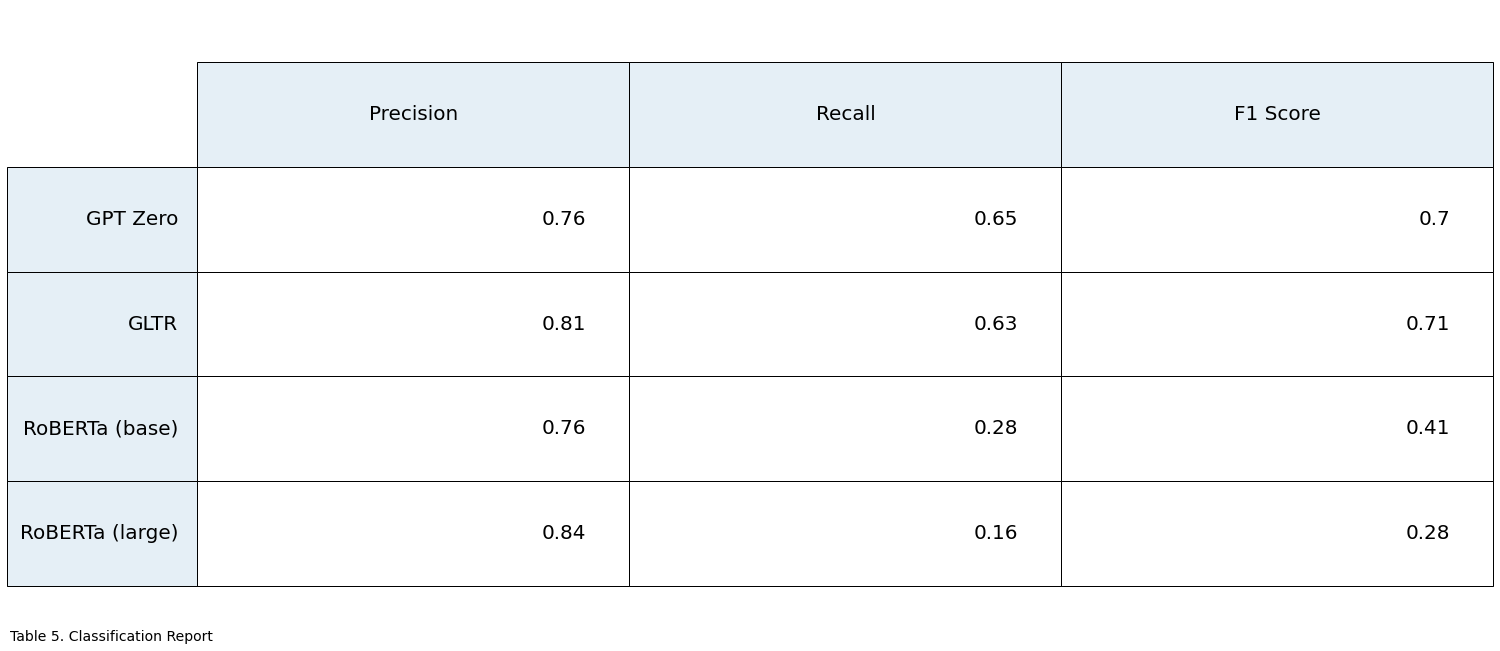

In [42]:
for col in ScoresDF.columns:
    ScoresDF[col] = ScoresDF[col].apply(lambda x: round(x, 2))

rcolors = plt.cm.BuPu(np.full(len(ScoresDF.index), 0.1))
ccolors = plt.cm.BuPu(np.full(len(ScoresDF.columns), 0.1))

the_table = plt.table(cellText=ScoresDF.values,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      rowLabels=ScoresDF.index,
                      colLabels=ScoresDF.columns,
                      loc='center'
                      )
plt.box(on=None)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplots_adjust(left=0.0, bottom=0.0)

plt.figtext(-.13, 0.00, "Table 5. Classification Report", horizontalalignment='left', size=14)
plt.gcf().set_size_inches(20, 10)

the_table.scale(1, 3)
plt.rcParams.update({'font.size': 20})

plt.savefig('ValidationGPT34.png', bbox_inches="tight")